In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

# m1芯片要用mps，NVIDIA 用cuda:0  0 表示第一个GPU 也可以是1、2、3、4
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

print(device)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.2.1
pandas 2.2.3
sklearn 1.6.0
torch 2.6.0
mps


## 数据准备


In [17]:
# 首先导入数据处理的库， 一个是数据集、一个是处理数据的工具集
from torchvision import datasets,transforms

# 定义一个数据集的变化过程，说白了就是封装对数据集的操作，后续方便处理

transform = transforms.Compose([
    transforms.ToTensor(), # 转化为tensor，进行归一化
    # transforms.Normalize(mean,std) # 标准化
])
# fashion_mnist图像分类数据集，衣服分类，60000张训练图片，10000张测试图片
train_ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_ds = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)


In [3]:
train_ds[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [13]:
# 查看train_ds 的每一个数据就发现特征和标签和在一起的，于是将他们分开
img,label = train_ds[0]
img.shape


AttributeError: 'Image' object has no attribute 'shape'

手动计算均值和方差

In [ ]:
#计算均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds: # 遍历每张图片,img.shape=[1,28,28]
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std


print(cal_mean_std(train_ds))

生成图像

In [14]:
# 显示图片，这里需要把transforms.ToTensor(),进行归一化注释掉，否则是不行的
def show_img_content(img):
    from PIL import Image

    # 打开一个图像文件
    # img = Image.open(img)


    print("图像大小:", img.size)
    print("图像模式:", img.mode)


    # 如果图像是单通道的，比如灰度图，你可以这样获取像素值列表：
    if img.mode == 'L':
        pixel_values = list(img.getdata())
        print(pixel_values)
show_img_content(img) #这里必须把上面的 transforms.ToTensor(), # 转换为tensor，进行归一化注释掉，否则是不行的

图像大小: (28, 28)
图像模式: L
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 13, 73, 0, 0, 1, 4, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 36, 136, 127, 62, 54, 0, 0, 0, 1, 3, 4, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 102, 204, 176, 134, 144, 123, 23, 0, 0, 0, 0, 12, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 236, 207, 178, 107, 156, 161, 109, 64, 23, 77, 130, 72, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 69, 207, 223, 218, 216, 216, 163, 127, 121, 122, 146, 141, 88, 172, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 200, 232, 232, 233, 229, 223, 223, 215, 213, 164, 127, 123, 196, 229, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 183, 225, 216, 223, 228, 235, 227, 224, 222, 224, 221, 223, 245, 173, 0, 0, 0, 

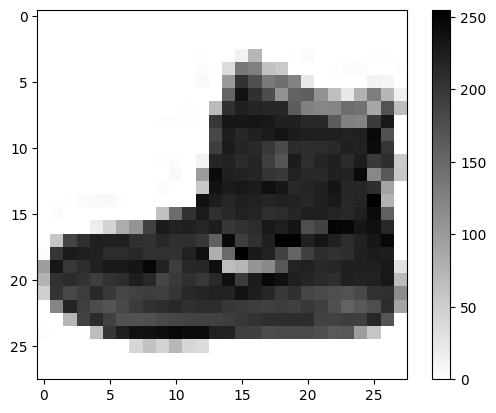

In [15]:
#这个代码必须是注释了上面的 transforms.ToTensor()才能够运行的
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap="binary") # 显示图片
    plt.colorbar() # 显示颜色条
    plt.show()


show_single_image(img)

展示图片群

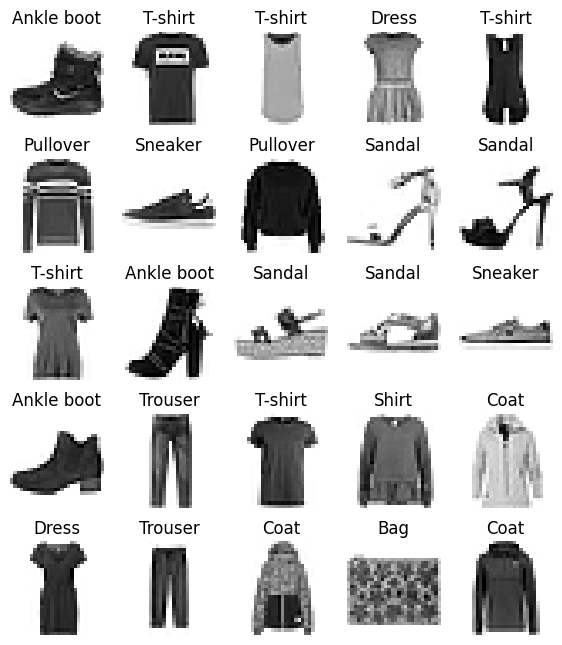

In [19]:
def show_imgs(n_rows, n_cols, train_ds, class_names):
    assert n_rows * n_cols < len(train_ds)  #确保打印的图片小于总样本数
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))  #宽1.4高1.6，宽，高
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col  # 计算索引，从0开始
            plt.subplot(n_rows, n_cols, index+1)#因为从1开始
            img_arr, label = train_ds[index]
            img_arr = np.transpose(img_arr, (1, 2, 0))  # 通道换到最后一维
            plt.imshow(img_arr, cmap="binary",
                       interpolation = 'nearest')#interpolation='nearest'是临近插值
            plt.axis('off')#去除坐标系
            plt.title(class_names[label]) # 显示类别名称
    plt.show()
    
    

#已知的图片类别
# lables在这个路径https://github.com/zalandoresearch/fashion-mnist
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot'] #0-9分别代表的类别
#只是打印了前15个样本
show_imgs(5, 5, train_ds, class_names)


In [20]:
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True) #batch_size分批，shuffle洗牌
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

在PyTorch中，`DataLoader`是一个迭代器，它封装了数据的加载和预处理过程，使得在训练机器学习模型时可以方便地批量加载数据。`DataLoader`主要负责以下几个方面：

1. **批量加载数据**：`DataLoader`可以将数据集（Dataset）切分为更小的批次（batch），每次迭代提供一小批量数据，而不是单个数据点。这有助于模型学习数据中的统计依赖性，并且可以更高效地利用GPU等硬件的并行计算能力。

2. **数据打乱**：默认情况下，`DataLoader`会在每个epoch（训练周期）开始时打乱数据的顺序。这有助于模型训练时避免陷入局部最优解，并且可以提高模型的泛化能力。

3. **多线程数据加载**：`DataLoader`支持多线程（通过参数`num_workers`）来并行地加载数据，这可以显著减少训练过程中的等待时间，尤其是在处理大规模数据集时。

4. **数据预处理**：`DataLoader`可以与`transforms`结合使用，对加载的数据进行预处理，如归一化、标准化、数据增强等操作。

5. **内存管理**：`DataLoader`负责管理数据的内存使用，确保在训练过程中不会耗尽内存资源。

6. **易用性**：`DataLoader`提供了一个简单的接口，可以很容易地集成到训练循环中。



## 定义模型

In [ ]:
"""
    自定义模型的参数初始化分为：
        1.简单随机初始化：均匀分布tf.random.uniform() 和 正态分布torch.randn()
        2.基于激活函数的初始化：
            Xavier/Glorot 初始化：适用于 Sigmoid、Tanh 等激活函数，根据输入和输出的维度调整初始化的方差。
                sigmoid 为饱和型激活函数，若初始化权重过大，会导致激活值进入饱和区导致梯度消失
            He/Kaiming 初始化：适用于 ReLU 及其变体，调整方差以适应 ReLU 的激活特性。
                ReLU 为非饱和性激活函数（正区间无界、负区间输出0），导致激活后的分布不再沿0对称
                由于ReLU会杀死一半的神经元（负值置零），输出的方差会减半，He初始化通过将方差放大一倍来补偿这种信息损失，确保梯度在反向传播时不会消失
        3.特殊初始化
    初始化的实际影响
        模型收敛速度：合理的初始化可以加速模型收敛。
        模型性能：糟糕的初始化可能导致模型无法收敛（如梯度爆炸）或陷入局部最优。
"""

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() # 继承父类的初始化方法，子类有父类的属性
        self.flatten = nn.Flatten()  # 展平层
        
        #将模型内部训练方法封装，便于后续使用
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 300),  # in_features=784, out_features=300, 784是输入特征数，300是输出特征数
            nn.ReLU(), # 激活函数
            nn.Linear(300, 100),#隐藏层神经元数100
            nn.ReLU(), # 激活函数
            nn.Linear(100, 10),#输出层神经元数10
        )
    
    def forward(self, x): # 前向计算
        # x.shape [batch size, 1, 28, 28]
        x = self.flatten(x)  
        # 展平后 x.shape [batch size, 784]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 10]
        return logits #没有经过softmax,称为logits
    
model = NeuralNetwork()

In [22]:
# 看看网络结构
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [23]:
for name, param in model.named_parameters(): # 打印模型参数
      print(name, param.shape)

linear_relu_stack.0.weight torch.Size([300, 784])
linear_relu_stack.0.bias torch.Size([300])
linear_relu_stack.2.weight torch.Size([100, 300])
linear_relu_stack.2.bias torch.Size([100])
linear_relu_stack.4.weight torch.Size([10, 100])
linear_relu_stack.4.bias torch.Size([10])


In [24]:
# 看看模型参数
list(model.parameters())  # 这种方法拿到模型的所有可学习参数,requires_grad=True


[Parameter containing:
 tensor([[ 0.0078,  0.0131,  0.0249,  ...,  0.0115,  0.0009, -0.0341],
         [ 0.0214, -0.0118, -0.0107,  ..., -0.0036, -0.0262,  0.0031],
         [-0.0235, -0.0203, -0.0184,  ...,  0.0070,  0.0034,  0.0201],
         ...,
         [ 0.0133,  0.0077,  0.0118,  ..., -0.0080, -0.0289, -0.0117],
         [ 0.0302,  0.0352,  0.0048,  ..., -0.0114,  0.0356, -0.0207],
         [-0.0287,  0.0230, -0.0144,  ...,  0.0183,  0.0078,  0.0267]],
        requires_grad=True),
 Parameter containing:
 tensor([-2.4924e-02,  4.0668e-03,  2.8799e-02, -3.2683e-02, -2.5517e-02,
          1.7863e-02, -5.2386e-03, -1.1192e-02,  2.3495e-03,  2.7277e-02,
         -6.1925e-03,  1.5458e-02,  2.1734e-02,  3.3125e-02,  3.3000e-02,
          4.2503e-03, -5.4279e-04,  4.9296e-03,  3.0560e-02,  1.7605e-02,
          1.9723e-03, -2.4513e-02,  3.5585e-02,  2.7144e-02, -1.2711e-02,
          3.1764e-02,  1.2740e-02, -2.0146e-02, -1.6751e-02, -3.0889e-02,
         -2.8325e-02, -2.9518e-02, -1.11

In [25]:
# model.state_dict()  # 这种方法用于保存模型参数，看能看见参数属于模型的哪一部分

## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

1. 定义损失函数
2. 定义优化器

In [26]:
loss_fct = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

这里先写一个训练方法，验证也是训练中的一步

In [28]:
from sklearn.metrics import accuracy_score

#验证过程中就不用反向传播了
@torch.no_grad() # 装饰器，禁止反向传播，节省内存
def evaluating(model, dataloader, loss_fct):
    loss_list = [] # 记录损失
    pred_list = [] # 记录预测
    label_list = [] # 记录标签
    for datas, labels in dataloader:#10000/32=312
        
        #将数据转到GPU
        datas = datas.to(device)
        labels = labels.to(device) 
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item()) # 记录损失
        
        preds = logits.argmax(axis=-1)    # 验证集预测,argmax返回最大值索引,就是返回对每一个样本的预测结果，生成数组，拿去跟label原类别数组进行比较，求准确率
        # print(preds)
        pred_list.extend(preds.cpu().numpy().tolist())#将PyTorch张量转换为NumPy数组。只有当张量在CPU上时，这个转换才是合法的
        # print(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list) # 计算准确率
    return np.mean(loss_list), acc


接下来是训练函数

In [29]:
# 训练
def training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=500):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar: # 进度条 1875*20,60000/32=1875
        for epoch_id in range(epoch): # 训练epoch次
            # training
            for datas, labels in train_loader: #执行次数是60000/32=1875
                datas = datas.to(device) #datas尺寸是[batch_size,1,28,28]
                labels = labels.to(device) #labels尺寸是[batch_size]
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传，loss.backward()会计算梯度，loss对模型参数求导
                loss.backward()
                # 调整优化器，包括学习率的变动等,优化器的学习率会随着训练的进行而减小，更新w,b
                optimizer.step() #梯度是计算并存储在模型参数的 .grad 属性中，优化器使用这些存储的梯度来更新模型参数

                preds = logits.argmax(axis=-1) # 训练集预测
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())   # 计算准确率，numpy可以
                loss = loss.cpu().item() # 损失转到CPU，item()取值,一个数值
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                }) # 记录训练集信息，每一步的损失，准确率，步数
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval() # 进入评估模式
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train() # 进入训练模式

                # udate step
                global_step += 1 # 全局步数加1
                pbar.update(1) # 更新进度条
                pbar.set_postfix({"epoch": epoch_id}) # 设置进度条显示信息
        
    return record_dict
        

epoch = 20 #改为40
model = model.to(device)
record = training(model, train_loader, val_loader, epoch, loss_fct, optimizer, eval_step=1000)

  0%|          | 0/37500 [00:00<?, ?it/s]

In [ ]:
# 查看结果
record["train"][-5:]

In [ ]:
record["val"][-5:]

step
0        0.12500
1000     0.59375
2000     0.87500
3000     0.78125
4000     0.87500
5000     0.81250
6000     0.84375
7000     0.87500
8000     0.81250
9000     0.78125
10000    0.81250
11000    0.81250
12000    0.87500
13000    0.84375
14000    0.90625
15000    0.90625
16000    0.78125
17000    0.87500
18000    0.84375
19000    0.90625
20000    0.87500
21000    0.96875
22000    0.93750
23000    0.90625
24000    0.75000
25000    0.93750
26000    0.87500
27000    0.87500
28000    0.87500
29000    0.87500
30000    0.84375
31000    0.81250
32000    0.96875
33000    0.87500
34000    0.93750
35000    0.90625
36000    0.90625
37000    0.96875
Name: acc, dtype: float64
step
0        0.1017
1000     0.6766
2000     0.7557
3000     0.7884
4000     0.8087
5000     0.8188
6000     0.8208
7000     0.8273
8000     0.8359
9000     0.8341
10000    0.8387
11000    0.8414
12000    0.8341
13000    0.8496
14000    0.8499
15000    0.8549
16000    0.8519
17000    0.8518
18000    0.8550
19000    0.859

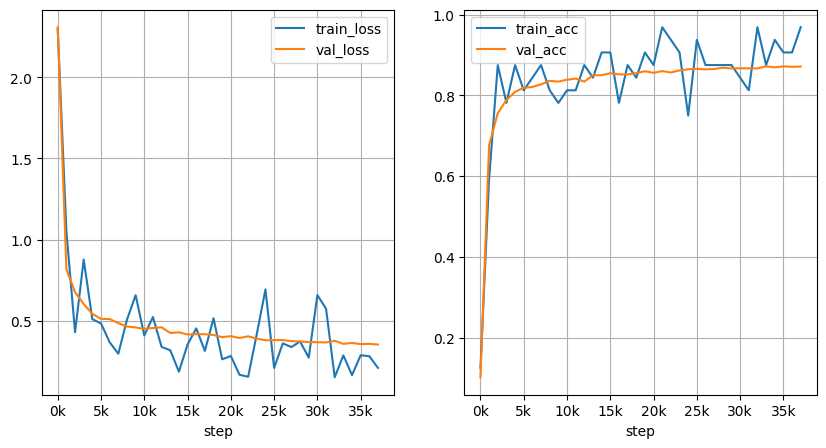

In [30]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=1000):
    # build DataFrame 把步数作为索引
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step] # 每1000步抓一个
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")
    last_step = train_df.index[-1] # 最后一步的步数
    # print(train_df.columns)
    print(train_df['acc'])
    print(val_df['acc'])
    # plot
    fig_num = len(train_df.columns) # 画几张图,分别是损失和准确率
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        # print(train_df[item].values)
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid() # 显示网格
        axs[idx].legend() # 显示图例
        axs[idx].set_xticks(range(0, train_df.index[-1], 5000)) # 设置x轴刻度
        axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, last_step, 5000))) # 设置x轴标签
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record)  #横坐标是 steps

## 评估

In [31]:
# dataload for evaluating

model.eval() # 进入评估模式
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3564
accuracy: 0.8710
